In [2]:
from google.colab import drive # the real images data files take too long (about 17 minutes) to be downloaded, so we just mount it
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-metadata.tgz && tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-samples.tgz # extract. this will take about 7 minutes

In [4]:
drive.flush_and_unmount() # unmount when we don't need it anymore, so we have more disk space

In [5]:
!mkdir train val

In [6]:
import json
import pandas as pd

def data_json_to_joined_df(path_prefix_to_json, percent = 100, random_sample=False):
    # percent: take only certain percent of the images
    # random_sample: True if you want to randomize which images to take

    category = pd.read_json(path_prefix_to_json + 'category.json').rename(columns={"name": "category_name"})
    category = category.sort_values(by='category_name')
    category['category_id'] = range(len(category))

    obj_ann = pd.read_json(path_prefix_to_json + 'object_ann.json')
    sample_data = pd.read_json(path_prefix_to_json + 'sample_data.json')
    sample_data = sample_data[sample_data['filename'].str.startswith('sample')] # take only keyframe images (annotated images) which always start with 'samples'. sweeps images are not annotated
    n_rows = int(len(sample_data) * (percent / 100))
    if random_sample:
        sample_data = sample_data.sample(n = n_rows)
    else:
        sample_data = sample_data.iloc[:n_rows]

    # object annotation inner join sample_data
    merged = obj_ann.merge(
        sample_data,
        how = 'inner',
        right_on='token',
        left_on='sample_data_token',
        suffixes=('_left', '_right')
    )

    merged = merged.merge(
        category,
        how = 'left',
        left_on='category_token',
        right_on='token',
        suffixes=('_from_merged', '_from_category')
    )

    return merged

# create list of train/val/test image file name list in a txt file (train/val.txt), so we can use cp/rsync with it
def create_image_filename_list_txt(data_split, merged_df):
    if data_split not in ['train', 'val', 'test']:
        return -1

    df = merged_df[['filename']]
    filenames = set([])
    for index, row in df.iterrows():
        filenames.add(row['filename'])
    for fn in filenames:
        with open(data_split+".txt", 'a') as f:
            f.write(fn + "\n")

def df_to_coco_format(merged_df, path_prefix, split): # DETR uses COCO format
    if split not in ['val', 'train']:
        return -1

    df = merged_df[['filename', 'bbox', 'category_id', 'category_name', 'width', 'height']]

    coco_dict = {"images": [], "annotations": [], "categories": []}
    is_image_added = {}
    filename_to_id = {}

    id = 0

    # build images
    for i, row in df.iterrows():
        if row['filename'] not in is_image_added: # if image not added yet, then add
            coco_dict["images"].append({
                "id": id,
                "width": row['width'],
                "height": row['height'],
                "file_name": row['filename'].split("/")[-1],
            })
            filename_to_id[row['filename']] = id
            id += 1
            is_image_added[row['filename']] = True

    # build annotations
    for i, row in df.iterrows():
        xmin, ymin, xmax, ymax = row['bbox'][0], row['bbox'][1], row['bbox'][2], row['bbox'][3]
        coco_dict["annotations"].append({
            "id": i,
            "image_id": filename_to_id[row['filename']],
            "category_id": row['category_id'],
            "area": (xmax - xmin) * (ymax - ymin),
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin], # top left, width, height
        })


    # build category
    category = pd.read_json(path_prefix + 'category.json').rename(columns={"name": "category_name"})
    category = category.sort_values(by='category_name')

    for i, row in category.iterrows():
        coco_dict["categories"].append({
            "id": i,
            "name": row["category_name"],
        })

    with open(split + ".json", "w") as file:
        file.write(json.dumps(coco_dict))


In [7]:
val_df = data_json_to_joined_df('/content/v1.0-val/',100, random_sample=False)
train_df = data_json_to_joined_df('/content/v1.0-train/',100, random_sample=True)
create_image_filename_list_txt('train', train_df)
create_image_filename_list_txt('val', val_df)

In [8]:
# make sure the val.txt exists before running this
# copy the val image to directory expected by yolo. should take about 1 minute for the entire dataset
!xargs -a val.txt -P8 -I{} cp "/content/{}" /content/val/

In [9]:
# make sure the train.txt exists before running this
# copy the train image to directory expected by yolo. should take about 5 minutes for the entire dataset
!xargs -a train.txt -P8 -I{} cp "/content/{}" /content/train/

In [10]:
df_to_coco_format(val_df, '/content/v1.0-val/', 'val')
df_to_coco_format(val_df, '/content/v1.0-train/', 'train')

In [11]:
!pip install pycocotools

In [12]:
!pip install scikit-image

loading annotations into memory...
Done (t=2.24s)
creating index...
index created!


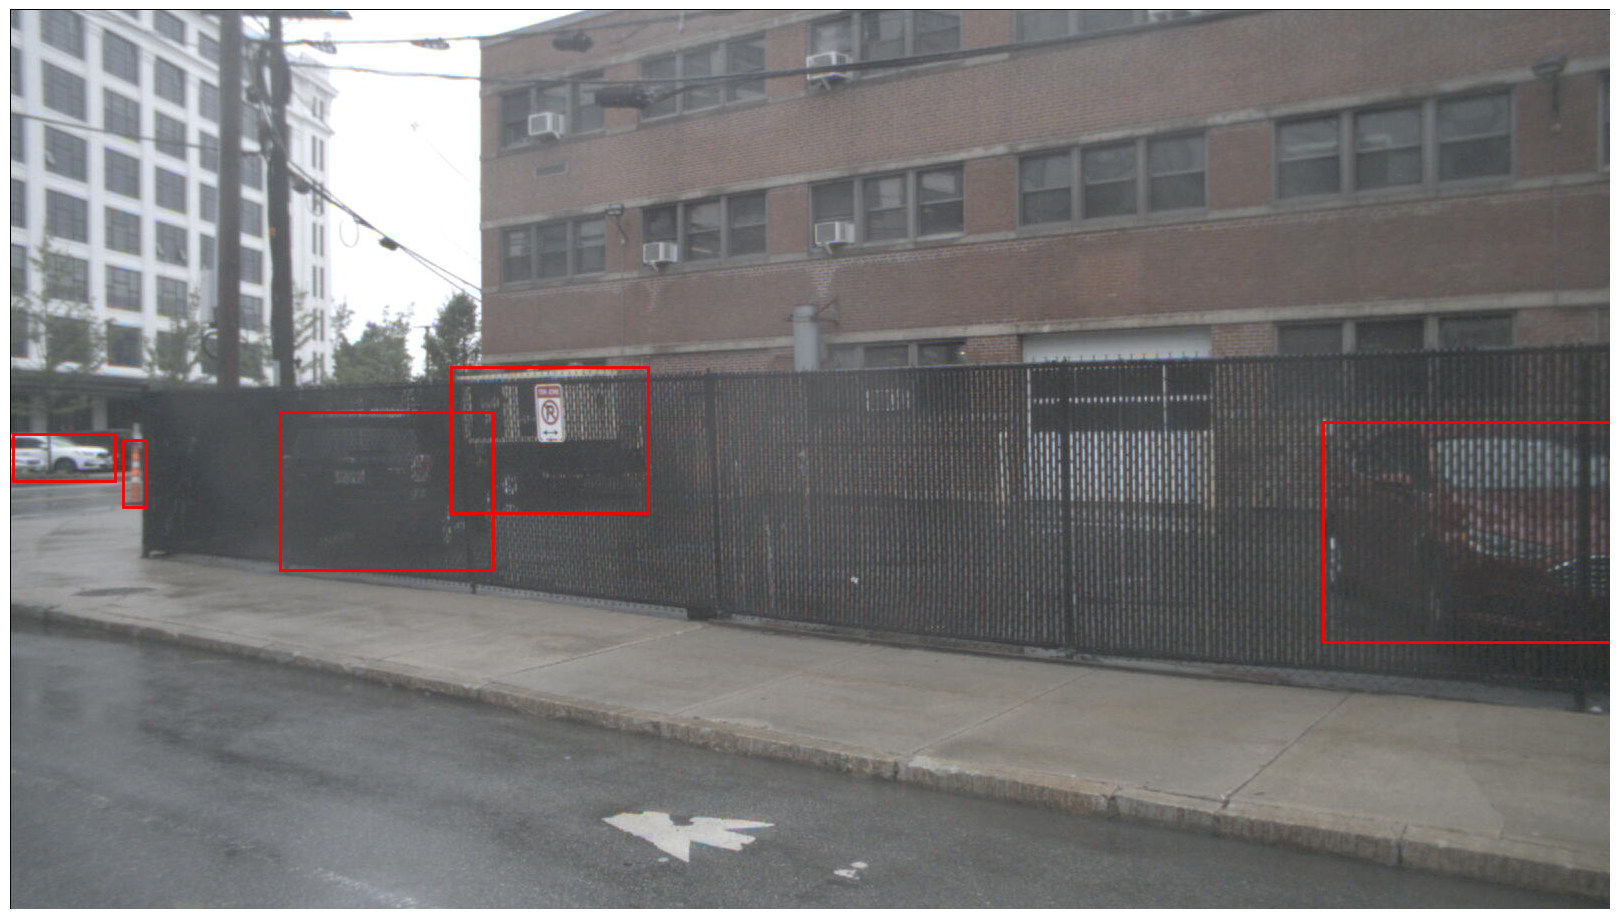

In [22]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import random

ann_file = '/content/val.json'
img_dir = '/content/val/'

coco = COCO(ann_file)

imgIds = coco.getImgIds()
img_id = imgIds[random.randint(1, len(imgIds)-1)]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(img_dir, img_info['file_name'])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

dpi = 100
height, width = img.shape[:2]
figsize = (width / dpi, height / dpi)

fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
ax.imshow(img)

for ann in anns:
    x, y, w, h = ann['bbox']
    rect = patches.Rectangle((x, y), w, h, linewidth=2,
                             edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.axis('off')
plt.tight_layout(pad=0)
plt.show()

